In [25]:
import pandas as pd
import numpy as np

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/X_train_G3tdtEn.csv')
test_Dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/X_test_8skS2ey.csv')
data_Y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/Y_train_2_XPXJDyy.csv')

df = dataframe.copy()

## change of the categorical data to numbers

list_uniqueLabel = []
list_col_object = []
list_dic_map = []
# Loop for that assign a each unique categorical value a number and after it reeplace the categorical value for this number
for col in df.columns:
    if df[col].dtypes == object:
        list_col_object.append(col)

for count in range(0,4):

    concate = pd.concat([dataframe[colum] for colum in list_col_object[(count*24):((count+1)*24)]])
    concate = pd.concat([test_Dataframe[columt] for columt in list_col_object[(count*24):((count+1)*24)]])
    concate = pd.concat([pd.Series([np.nan]),concate])

    list_uniqueLabel.append(concate.unique())

    # dictionary
    dic_map = {label : index for index, label in enumerate(list_uniqueLabel[-1])}

    # Replace the values in dataframe

    for colob in range(0,24):
        df[list_col_object[colob+count*24]] = df[list_col_object[colob+count*24]].map(dic_map)

    list_dic_map.append(dic_map.copy())
    dic_map.clear()


<ipython-input-27-35fd0dae2bd3>:1: DtypeWarning: Columns (21,22,23,24,69,70,71,72,93,94,95,96,97,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/X_train_G3tdtEn.csv')
<ipython-input-27-35fd0dae2bd3>:2: DtypeWarning: Columns (20,21,22,23,24,68,69,70,71,72,92,93,94,95,96,97,106,107,108,109,110,111,112,113,114,115,116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
  test_Dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/X_test_8skS2ey.csv')


In [28]:
# Reemplace the 0 in the converted columns to his true value NaN
df[list_col_object] = df[list_col_object].replace(0,np.nan)

# Verification exact coincidence

exact_coincidence = (df['ID'] == data_Y['ID']).all()
print(exact_coincidence)

# we put out the columns that not contribute to the prediction

df = df.drop('ID',axis=1)
data_Y = data_Y.drop(['index','ID'], axis=1)

True


In [29]:
dataX = np.array(df)
dataY = np.array(data_Y)

print(dataX.shape)
print(dataY.shape)

print(np.sum(np.isnan(dataX)))

(92790, 145)
(92790, 1)
12415322


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Remplace the NaN values

constant_imputer = SimpleImputer(strategy='constant')
dataX_imp = constant_imputer.fit_transform(dataX)

# normalizacion

scaler = MinMaxScaler(feature_range=(0, 1))
dataX_n = scaler.fit_transform(dataX_imp)

# Split of the data for validation set

# training_input_t,val_input,training_output_t,val_output = train_test_split(dataX_n, data_Y, test_size=0.2)

training_input_t,training_output_t = dataX_n,data_Y

training_input_t,test_input,training_output_t,test_output = train_test_split(training_input_t,training_output_t,test_size=0.1)


In [31]:
# BORDERLINE SMOTE technique (evolution SMOTE)

from imblearn.over_sampling import BorderlineSMOTE

# Return to dataframe

df_train = pd.DataFrame(training_input_t,columns=df.columns)
datY_train = pd.DataFrame(training_output_t,columns=data_Y.columns)

# Aplication of SMOTE only in the training data (test is with the original values)

count_minoritary_class = len(datY_train[datY_train['fraud_flag'] == 1])
smote = BorderlineSMOTE(sampling_strategy={1:(10*count_minoritary_class)}, random_state=42) # the {1:4} means have the class with label 1, 4 times, so increase 3 values

df_smote,data_y_smote = smote.fit_resample(df_train,datY_train)

# Print number each class
print('class distribution before SMOTE')
print(datY_train['fraud_flag'].value_counts())
print('\n')
print('class distribution after SMOTE')
print(data_y_smote['fraud_flag'].value_counts())

print(df_train.shape)
print(df_smote.shape)

# Conversion to array
dataX_a = np.array(df_smote)
dataY_a = np.array(data_y_smote)

# Determination of training data
training_input,training_output = dataX_a,dataY_a

class distribution before SMOTE
0    82309
1     1202
Name: fraud_flag, dtype: int64


class distribution after SMOTE
0    82309
1    12020
Name: fraud_flag, dtype: int64
(83511, 145)
(94329, 145)


In [32]:
# from imblearn.under_sampling import RandomUnderSampler

# # Aplication undersampling random

# count_minoritary_class_u = len(data_y_smote[data_y_smote['fraud_flag'] == 1])
# rus = RandomUnderSampler(sampling_strategy={0:2*count_minoritary_class_u}, random_state=42)
# dataX_a,dataY_a = rus.fit_resample(df_smote, data_y_smote)

# # Print number each class
# print('class distribution before Undersampling')
# print(data_y_smote['fraud_flag'].value_counts())
# print('\n')
# print('class distribution after Undersampling')
# print(dataY_a['fraud_flag'].value_counts())

# dataX_a = np.array(dataX_a)
# dataY_a = np.array(dataY_a)

# # Determination of training data
# training_input,training_output = dataX_a,dataY_a

In [33]:
import tensorflow as tf

# Function to improve the learning rate

def adapt_learning_rate(epoch):
    lr=0.001
    if epoch>100:
        lr=0.0001
    if epoch>200:
        lr=0.00005
    if epoch>240:
        lr=0.00001
    if epoch>700:
        lr=0.000005

    return lr

my_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate)

In [34]:
# Neural Network

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

# Network

model = Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(145,)))
model.add(Dense(100,activation='relu'))
model.add(Dense(200,activation='tanh'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(250,activation='selu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(500,activation='elu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(250,activation='selu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(150,activation='relu'))
model.add(Dense(1,activation='sigmoid')) # Output

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 100)               14600     
                                                                 
 dense_8 (Dense)             (None, 200)               20200     
                                                                 
 batch_normalization_4 (Bat  (None, 200)               800       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_9 (Dense)             (None, 250)               50250     
                                                                 
 batch_normalization_5 (Bat  (None, 250)               1000      
 chNormalization)                                     

In [35]:
from sklearn.metrics import average_precision_score

# Define the metric average_precision as a personalised function
def average_precision(y_true, y_pred):
    return tf.py_function(average_precision_score, (y_true, y_pred), tf.float64)

In [36]:
import tensorflow as tf
from keras.losses import Loss
import keras.backend as K
from tensorflow.python.ops import math_ops

class CustomLossMSFE_Orig(Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        # Obtain index for y_true where it's 0
        indices_y_true_equals_0 = tf.where(tf.equal(y_true, 0)[:, 0])

        # Filter y_true and y_pred with the founded index
        y_true_0 = tf.gather(y_true, indices_y_true_equals_0)
        y_pred_0 = tf.gather(y_pred, indices_y_true_equals_0)

        # Calcul of number of samples where y_true is 0
        n = tf.cast(tf.shape(y_true_0)[0], dtype=tf.float32)

        # uncomment for give more learning to majority class
        # n = 0.8 * n

        # Convert tensors to float32
        y_true_0 = tf.cast(y_true_0, dtype=tf.float32)
        y_pred_0 = tf.cast(y_pred_0, dtype=tf.float32)

        # Calcul of the addition of the mean squared errors for each neuron with y_true equal 0
        diff_0 = math_ops.squared_difference(y_true_0, y_pred_0)
        diff_0 = diff_0 / 2

        red_sum_0 = tf.reduce_sum(diff_0)

        # Obtain index for y_true where it's 1
        indices_y_true_equals_1 = tf.where(tf.equal(y_true, 1)[:, 0])

        # Filter y_true and y_pred with the founded index
        y_true_1 = tf.gather(y_true, indices_y_true_equals_1)
        y_pred_1 = tf.gather(y_pred, indices_y_true_equals_1)

        # Calcul of number of samples where y_true is 1
        p = tf.cast(tf.shape(y_true_1)[0], dtype=tf.float32)
        p = 0.5 * p

        # Convert tensors to float32
        y_true_1 = tf.cast(y_true_1, dtype=tf.float32)
        y_pred_1 = tf.cast(y_pred_1, dtype=tf.float32)

        # Calcul of the addition of the mean squared errors for each neuron with y_true equal 0
        diff_1 = math_ops.squared_difference(y_true_1, y_pred_1)
        diff_1 = diff_1 / 2

        red_sum_1 = tf.reduce_sum(diff_1)

        # Calcul of the loss with the addition of both errors
        loss = (red_sum_0 / n)**2 + (red_sum_1 / p)**2

        return loss

In [37]:
model.compile(optimizer='adam',
                loss=CustomLossMSFE_Orig(),
                metrics=[average_precision])

In [38]:
# Weights for the learning for each target label

weights = {0:1, 1:1} # 7 Label (1) have 100 times more importance in the learning than label (0)

In [39]:
# history1 = model.fit(training_input,training_output,batch_size=800,epochs=60,
#                     shuffle=True,callbacks=my_lr_scheduler,class_weight=weights,validation_data=(val_input,val_output))

history1 = model.fit(training_input,training_output,batch_size=800,epochs=70,
                    shuffle=True,callbacks=my_lr_scheduler,class_weight=weights)



Epoch 1/70
118/118 [==============================] - 6s 10ms/step - loss: 0.0408 - average_precision: 0.2874 - lr: 0.0010
Epoch 2/70
118/118 [==============================] - 1s 9ms/step - loss: 0.0292 - average_precision: 0.3786 - lr: 0.0010
Epoch 3/70
118/118 [==============================] - 1s 9ms/step - loss: 0.0262 - average_precision: 0.3997 - lr: 0.0010
Epoch 4/70
118/118 [==============================] - 1s 9ms/step - loss: 0.0237 - average_precision: 0.4251 - lr: 0.0010
Epoch 5/70
118/118 [==============================] - 1s 9ms/step - loss: 0.0229 - average_precision: 0.4366 - lr: 0.0010
Epoch 6/70
118/118 [==============================] - 1s 9ms/step - loss: 0.0214 - average_precision: 0.4436 - lr: 0.0010
Epoch 7/70
118/118 [==============================] - 1s 10ms/step - loss: 0.0201 - average_precision: 0.4714 - lr: 0.0010
Epoch 8/70
118/118 [==============================] - 1s 9ms/step - loss: 0.0191 - average_precision: 0.4817 - lr: 0.0010
Epoch 9/70
118/118 [==

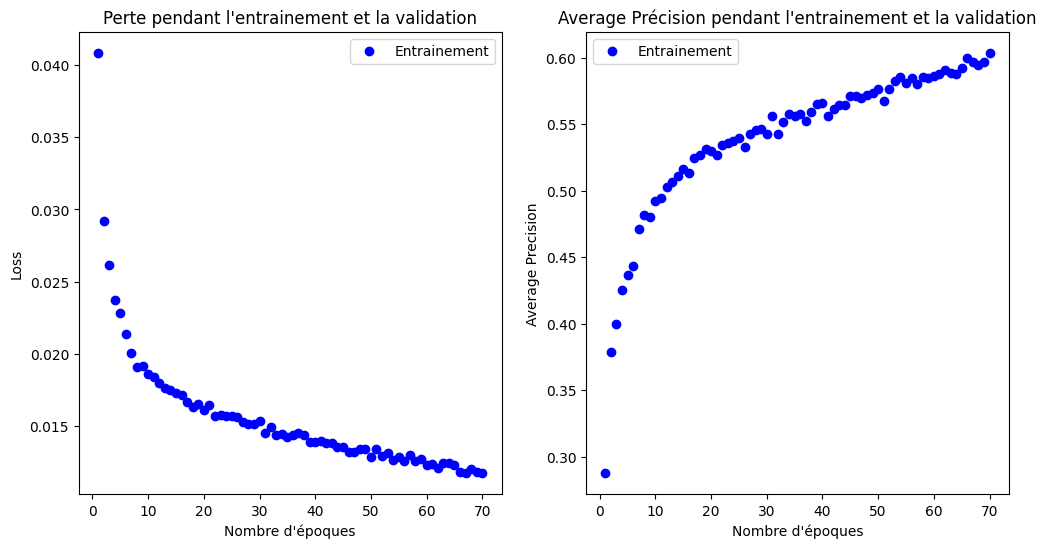

In [40]:
# Visualization of the model

import matplotlib.pyplot as plt

# plot fonction perte

loss=history1.history['loss']

# val_loss = history1.history['val_loss']
epochs = range(1,len(loss)+1)

plt.figure(figsize=(12,6))


plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label = 'Entrainement')
# plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Perte pendant l\'entrainement et la validation')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Loss')
plt.legend()

# plot precision du model

avp = history1.history['average_precision']
# val_avp = history1.history['val_average_precision']

plt.subplot(1,2,2)
plt.plot(epochs,avp,'bo',label='Entrainement')
# plt.plot(epochs, val_avp, 'b', label='Validation')
plt.title('Average Précision pendant l\'entrainement et la validation')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Average Precision')
plt.legend()
plt.savefig('loss_accuracy_model.jpg')
plt.show()

In [41]:
test_output = np.array(test_output)

In [42]:
# Validation of model performance with new data

y_pred = model.predict(test_input)

counter_p = len([valor for valor in y_pred if valor > 0.5])
counter_r = len([valor_r for valor_r in test_output if valor_r > 0.5])
print('There are ',counter_p, ' labels (1) predicted')
print('There are ',counter_r, ' labels (1) in the reality')

print('Neural Network PR-AUC = ',average_precision_score(test_output,y_pred))

y_pred_int = [1 if value > 0.5 else 0 for value in y_pred]

print('Neural Network PR-AUC (binary) = ',average_precision_score(test_output,y_pred_int))

290/290 [==============================] - 1s 2ms/step
There are  2548  labels (1) predicted
There are  117  labels (1) in the reality
Neural Network PR-AUC =  0.05245924644812869
Neural Network PR-AUC (binary) =  0.026772642378423597


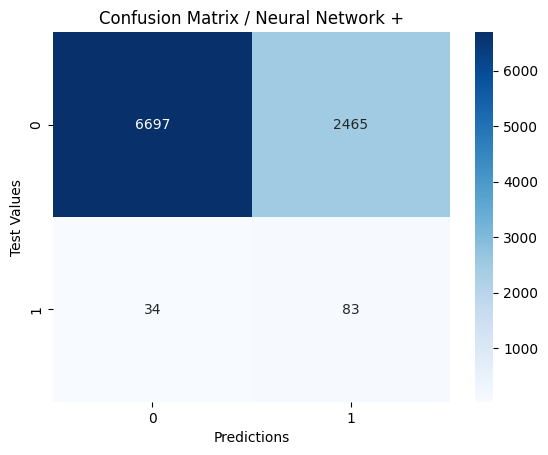

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

prediction = (y_pred > 0.5).astype(int)

# Uncomment to view the model's Confusion Matrix

conf_matrix_features = confusion_matrix(test_output, prediction)

sns.heatmap(conf_matrix_features, annot = True, fmt = 'd', cmap='Blues')

plt.xlabel('Predictions')
plt.ylabel('Test Values')
plt.title('Confusion Matrix / Neural Network +')
plt.savefig('conf_matrix_NeuralNetwork.jpg')
plt.show()

TRATMENT OF THE TEST DATA

In [45]:
test_Dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/X_train_G3tdtEn.csv')
test = test_Dataframe.copy()

# Loop for that assign a each unique categorical value a number and after it reeplace the categorical value for this number

for count_1 in range(0,4):

    # dictionary
    dic_map_1 = list_dic_map[count_1]

    # Replace the values in dataframe

    for colob_1 in range(0,24):
        test[list_col_object[colob_1+count_1*24]] = test[list_col_object[colob_1+count_1*24]].map(dic_map_1)


<ipython-input-45-85b7a3d3772d>:1: DtypeWarning: Columns (21,22,23,24,69,70,71,72,93,94,95,96,97,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  test_Dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge_data_BNP/X_train_G3tdtEn.csv')


In [46]:
# Reemplace the 0 in the converted columns to his true value NaN
test[list_col_object] = test[list_col_object].replace(0,np.nan)

# we put out the columns that not contribute to the prediction
test = test.drop('ID',axis=1)


In [47]:
dataX = np.array(test)

print(dataX.shape)

print(np.sum(np.isnan(dataX)))

(92790, 145)
12415322


In [48]:
# Remplace the NaN values

constant_imputer = SimpleImputer(strategy='constant')
dataX_imp = constant_imputer.fit_transform(dataX)

# normalizacion

scaler = MinMaxScaler(feature_range=(0, 1))
dataX_test = scaler.fit_transform(dataX_imp)

PREDICTION AND GENERATION OF THE Y TEST

In [49]:
# Prediction

y_pred = model.predict(dataX_test)

counter_p = len([valor for valor in y_pred if valor > 0.5])
print('There are ',counter_p, ' labels (1) predicted')

Y_test = pd.DataFrame(np.column_stack([test_Dataframe['ID'],y_pred]),columns=['ID','fraud_flag'])
Y_test.to_csv('Y_test.csv', index=True,index_label='index')
print(y_pred)

2900/2900 [==============================] - 6s 2ms/step
There are  26079  labels (1) predicted
[[3.5561639e-01]
 [1.1104653e-03]
 [2.3803214e-02]
 ...
 [1.3000515e-06]
 [2.7434426e-04]
 [7.5546987e-03]]
